In [1]:
#!!!!注意，請先執行這個區塊，依網頁指示通過授權後載入 Google 雲端硬碟, 再執行底下的程式
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# 13.4 以「函數式 API」建構非序列式 NLP 模型

#### 載入套件

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # new!
from tensorflow.keras.layers import Input, concatenate # new! 
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 設定超參數

In [4]:
# 輸出目錄名稱：
output_dir = '/content/drive/MyDrive/Colab Notebooks/F1383_Sample/Ch13/model_output/multiconv'  #註：請記得依你存放的位置彈性修改路徑

# 訓練：
epochs = 4
batch_size = 128

# 嵌入詞向量空間： 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# 卷積層架構：
n_conv_1 = n_conv_2 = n_conv_3 = 256 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# 密集層架構： 
n_dense = 256
dropout = 0.2

#### 載入資料集

In [5]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words) 

17473536/17464789 [==============================] - 0s 0us/step


#### 資料預處理

In [6]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_test = pad_sequences(x_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 神經網路架構

In [7]:
input_layer = Input(shape=(max_review_length,), 
                    dtype='int16', name='input') 

# embedding: 
embedding_layer = Embedding(n_unique_words, n_dim, 
                            name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, 
                                    name='drop_embed')(embedding_layer)

# three parallel convolutional streams: 
conv_1 = Conv1D(n_conv_1, k_conv_1, 
                activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, 
                activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, 
                activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenate the activations from the three streams: 
concat = concatenate([maxp_1, maxp_2, maxp_3])

# dense hidden layers: 
dense_layer = Dense(n_dense, 
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4), 
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# sigmoid output layer: 
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

# create model: 
model = Model(input_layer, predictions)

In [8]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
______________________________________________________________________________________________

#### 編譯模型

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 訓練模型

In [11]:
#註：由於神經網路的初始權重參數是隨機設定的, 參雜了隨機性, 因此底下 (或您重跑一次) 的結果不會與書中完全一樣, 但模型的能力是相近的
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 197s 998ms/step - loss: 0.4861 - accuracy: 0.7385 - val_loss: 0.2847 - val_accuracy: 0.8801
Epoch 2/4
196/196 [==============================] - 195s 995ms/step - loss: 0.2477 - accuracy: 0.9018 - val_loss: 0.2512 - val_accuracy: 0.8982
Epoch 3/4
196/196 [==============================] - 193s 987ms/step - loss: 0.1714 - accuracy: 0.9350 - val_loss: 0.3232 - val_accuracy: 0.8720
Epoch 4/4
196/196 [==============================] - 193s 987ms/step - loss: 0.1142 - accuracy: 0.9610 - val_loss: 0.2782 - val_accuracy: 0.8941


#### 評估結果

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5")   #請視以上執行結果指定較佳的權重

In [ ]:
y_hat = model.predict(x_test)

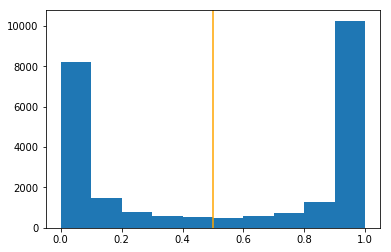

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
#註：由於神經網路的初始權重參數是隨機設定的, 參雜了隨機性, 因此底下 (或您重跑一次) 的結果不會與書中完全一樣, 但模型的能力是相近的
"{:0.2f}".format(roc_auc_score(y_test, y_hat)*100.0)

'96.18'